<a href="https://colab.research.google.com/github/Riddars/Hakaton_04.09.23/blob/main/%D0%A7%D0%B5%D1%80%D0%BD%D0%BE%D0%B2%D0%BE%D0%B9%20%D0%B2%D0%B0%D1%80%D0%B8%D0%B0%D0%BD%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit
!pip install pycaret
!pip install lazypredict

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import datasets
from sklearn.utils import shuffle

from rdkit import Chem
from rdkit.Chem import Descriptors

import networkx as nx


import lazypredict
from lazypredict.Supervised import LazyRegressor #Regression

import pickle

import tensorflow as tf


In [ ]:
# Загрузка данных из CSV файлов
data_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Hakaton_04.09.23/main/dataset_3090.csv', index_col=0)

NameError: ignored

In [ ]:
#смотрим, какие вообще есть данные
data_df.head(2)

,Material,Diameter (nm),Zeta potential (mV),Cell_type,Concentration (g/L),Viability (%),Coat,Line_Primary_Cell,Animal,Cell_morphology,Cell_age,Cell_organ,Time (h),Test,Test_indicator,Molecular weight (g/mol),Electronegativity,Elements,Ionic radius
0,Ag,28.41,-33.33,HeLa,0.00,3.66,0,L,human,Epithelial,Adult,cervix,72.00,MTT,TetrazoliumSalt,107.87,1.93,Ag,1.09
1,Ag,28.41,-33.33,HeLa,0.00,48.48,0,L,human,Epithelial,Adult,cervix,48.00,NR,toluylene red,107.87,1.93,Ag,1.09


# Основной датасет

In [ ]:
# смотрим нет ли непонятных значений во всех столбцах
for column in data_df.columns:
    unique_values = data_df[column].unique()
    print(f"Уникальные значения в столбце '{column}': {unique_values}")

Уникальные значения в столбце 'Material': ['Ag' 'Al2O3' 'Au' 'C23H40N2O18' 'C56H103N9O39' 'C9H15N3O6' 'CdO' 'CeO2'
 'Co3O4' 'Cu2O' 'CuO' 'Fe3O4' 'MgO' 'MnO' 'NiO' 'Pt' 'Se' 'SiO2' 'TiO2'
 'ZnO' 'ZrO2']
Уникальные значения в столбце 'Diameter (nm)': [ 28.41  14.7   36.4   27.02 100.   239.    45.    28.    39.7   13.
  21.7   25.    90.   215.    18.    50.     6.     6.3   30.   270.
  61.46  33.69  65.    20.     5.    38.    46.    60.    95.5  143.67
  98.4   93.13 360.    40.   265.   240.   155.   159.   260.   188.
 122.    11.7   14.3    3.6    5.3  179.3   12.5    4.7   33.    20.3
 200.    78.3   88.5   22.83  46.3   28.2   10.    55.8   52.51  30.09
  23.    28.33  42.5   46.8  145.8  361.4  326.5   13.5   22.   274.1
  36.    14.   196.4  957.   639.    12.     8.    39.2   24.    21.6
  24.6   20.12   1.5   79.6   21.06 120.     9.   280.    18.3   19.4
 199.89  55.6  307.6  167.8   59.72 100.33  31.4   56.7   19.1   21.8
 369.    96.   375.4   29.5   15.   598.2   14.23 43

In [ ]:
# метод value_counts() для подсчета значений в столбце "Animal"
animal_counts = data_df['Animal'].value_counts()

# сколько строк содержат значение "0"
count_of_zeros = animal_counts.get('0', 0)

# результат
print(f"Количество строк со значением '0' в столбце 'Animal': {count_of_zeros}")

Количество строк со значением '0' в столбце 'Animal': 0


In [ ]:
# удаляем строчки где в столбце "Animal" значение 0 (их всего 10)
data_df = data_df[data_df['Animal'] != '0']

In [ ]:
# Проверка типов данных в каждом столбце
data_types = data_df.dtypes
# Вывод результатов
print("\nТипы данных:")
print(data_types)


Типы данных:
Material                     object
Diameter (nm)               float64
Zeta potential (mV)         float64
Cell_type                    object
Concentration (g/L)         float64
Viability (%)               float64
Coat                         object
Line_Primary_Cell            object
Animal                       object
Cell_morphology              object
Cell_age                     object
Cell_organ                   object
Time (h)                    float64
Test                         object
Test_indicator               object
Molecular weight (g/mol)    float64
Electronegativity           float64
Elements                     object
Ionic radius                float64
dtype: object


In [ ]:
# Функция, кодирующая все синтезы на три типа - химический, зелёный (для восстановления используются экстракты из грибов/бактерий и тд, что может влиять на оболочку НЧ),
# и био - НЧ синтезируются с помощью бактерий/грибов
def add_synthesis_encoding(data_df):
    data_df['NP_Synthesis_Chem'] = data_df['NP_Synthesis'].str.contains('chem').astype(int)
    data_df['NP_Synthesis_Green'] = data_df['NP_Synthesis'].str.contains('extract').astype(int)
    condition = (data_df['NP_Synthesis_Chem'] == 0) & (data_df['NP_Synthesis_Green'] == 0)
    data_df.loc[condition, 'NP_Synthesis_Bio'] = 1
    data_df.loc[~condition, 'NP_Synthesis_Bio'] = 0
    data_df = data_df.drop(columns = 'NP_Synthesis')


### Run!

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3077 entries, 0 to 3086
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Material                  3077 non-null   object 
 1   Diameter (nm)             3077 non-null   float64
 2   Zeta potential (mV)       3077 non-null   float64
 3   Cell_type                 3077 non-null   object 
 4   Concentration (g/L)       3077 non-null   float64
 5   Viability (%)             3077 non-null   float64
 6   Coat                      3077 non-null   object 
 7   Line_Primary_Cell         3077 non-null   object 
 8   Animal                    3077 non-null   object 
 9   Cell_morphology           3077 non-null   object 
 10  Cell_age                  3077 non-null   object 
 11  Cell_organ                3077 non-null   object 
 12  Time (h)                  3077 non-null   float64
 13  Test                      3077 non-null   object 
 14  Test_ind

(3077, 19)


<Axes: >

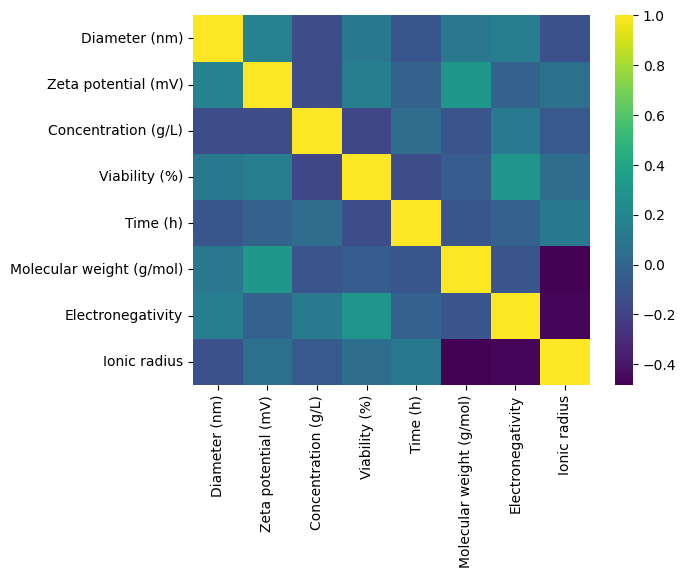

In [ ]:
# посмотрим корреляцию столбцов с числовыми значениями
print(data_df.shape)
sns.heatmap(data_df.corr(), cmap='viridis', yticklabels=True)


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3077 entries, 0 to 3086
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Material                  3077 non-null   object 
 1   Diameter (nm)             3077 non-null   float64
 2   Zeta potential (mV)       3077 non-null   float64
 3   Cell_type                 3077 non-null   object 
 4   Concentration (g/L)       3077 non-null   float64
 5   Viability (%)             3077 non-null   float64
 6   Coat                      3077 non-null   object 
 7   Line_Primary_Cell         3077 non-null   object 
 8   Animal                    3077 non-null   object 
 9   Cell_morphology           3077 non-null   object 
 10  Cell_age                  3077 non-null   object 
 11  Cell_organ                3077 non-null   object 
 12  Time (h)                  3077 non-null   float64
 13  Test                      3077 non-null   object 
 14  Test_ind

In [ ]:
# пример того как превратить данные типа object в тип int
def last_preparation(df):
    df['shape']= df['shape'].map({'spherical' : 0,
                'nanorods and triangles' : 1
                })
    df["shape"] = df["shape"].astype(int)

last_preparation(df)


# autoML

In [ ]:
#Для пробы сделали два разных AutoML

## PyCaret

In [ ]:
from pycaret.regression import *


exp1 = setup(
    data_df,
    target='ZOI_drug_NP', session_id = 4221,
    normalize = True,
    normalize_method = 'robust',
    polynomial_features = True,
    polynomial_degree = 2,
    )

,Description,Value
0,Session id,4221
1,Target,ZOI_drug_NP
2,Target type,Regression
3,Original data shape,"(451, 20)"
4,Transformed data shape,"(451, 210)"
5,Transformed train set shape,"(315, 210)"
6,Transformed test set shape,"(136, 210)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best = exp1.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2.3382,13.4213,3.5205,0.7762,0.1763,0.1323,0.4930
br,Bayesian Ridge,2.3918,13.5615,3.5135,0.7665,0.2079,0.1447,0.1580
rf,Random Forest Regressor,2.3667,13.9498,3.6006,0.7581,0.1903,0.1402,0.6880
lightgbm,Light Gradient Boosting Machine,2.4804,14.5663,3.6627,0.7510,0.1944,0.1455,0.2240
ada,AdaBoost Regressor,2.9315,15.9442,3.8886,0.7315,0.2030,0.1751,0.2810
et,Extra Trees Regressor,2.3917,16.3476,3.8922,0.7170,0.2072,0.1441,0.6910
xgboost,Extreme Gradient Boosting,2.5571,16.6661,3.9609,0.7167,0.2058,0.1485,0.4620
en,Elastic Net,2.9570,16.4512,3.9531,0.7058,0.2090,0.1801,0.1740
llar,Lasso Least Angle Regression,3.0004,17.2326,4.0283,0.6942,0.2200,0.1895,0.2550
lasso,Lasso Regression,3.0274,17.4700,4.0607,0.6906,0.2222,0.1913,0.5070


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
#ПАРАМЕТРЫ лучшей модели - Gradient Boosting Regressor
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
model_gbr = exp1.create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.0396,7.1387,2.6718,0.7806,0.1662,0.1437
1,2.4325,11.6391,3.4116,0.8240,0.1690,0.1335
2,2.9198,18.7831,4.3339,0.7699,0.1900,0.1360
3,3.6915,36.8681,6.0719,0.6531,0.2049,0.1462
4,2.6006,15.0470,3.8791,0.8282,0.2201,0.1868
5,2.2667,11.9788,3.4610,0.7825,0.1775,0.1338
6,1.7959,6.1798,2.4859,0.8705,0.1336,0.1050
7,1.8977,7.3372,2.7087,0.9157,0.1404,0.1200
8,1.9263,7.9780,2.8245,0.8535,0.1523,0.1048


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
evaluate_model(model_gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
save_model(model_gbr,'model_gbr.pkl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Drug_dose', 'NP_concentration',
                                              'NP size_min', 'NP size_max',
                                              'shape', 'ZOI_drug', 'MDR_check',
                                              'NP_Synthesis_Chem',
                                              'NP_Synthesis_Green',
                                              'NP_Synthesis_Bio', 'gram',
                                              'min_Incub_period, h',
                                              'biosafety_level', 'MolLogP',
                                              'fr_lactam',
                                              'NumAromaticHeterocycles',
                                              'd_...
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'

# LasyRegressor

## Загружаю библиотеки

## LazyPredict

При помощи библиотеки LazyPredict подбираем модель регрессии

In [ ]:


x = df.columns
target_name = 'ZOI_drug_NP'

X, y = df[x.drop(target_name)], df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [ ]:
reg = LazyRegressor(predictions=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:03<00:00, 11.55it/s]


In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.75,0.80,3.96,0.13
GradientBoostingRegressor,0.73,0.79,4.09,0.14
RandomForestRegressor,0.73,0.78,4.11,0.18
XGBRegressor,0.72,0.78,4.16,0.06
BaggingRegressor,0.71,0.77,4.20,0.03
LGBMRegressor,0.66,0.73,4.59,0.05
HistGradientBoostingRegressor,0.65,0.72,4.65,0.16
AdaBoostRegressor,0.65,0.72,4.66,0.07
Lars,0.63,0.71,4.76,0.03


Для модели с лучшими результатами R**2 и RMSE подбираем оптимальные параметры при помощи gridsearchCV

In [ ]:
def make_gridsearchCV(models_params: list, df: pd.DataFrame, test_size=0.25, cv=4, random_state=123, target_name='ZOI_drug_NP'):

    X, y = df[x.drop(target_name)], df[target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    models = []

    for model in models_params:

        pipe = Pipeline([('scaler', MinMaxScaler()), ('model', model[0])])
        grid = GridSearchCV(pipe, model[1], scoring='r2', n_jobs=-1, cv=cv)
        grid.fit(X_train, y_train)

        print(f'--- Model: {pipe["model"].__class__.__name__} ---\n')
        print(f'Best params: {grid.best_params_}')
        print(f'Best CV R2 score: {grid.best_score_}')
        print(f'R2 score on unseen data: {r2_score(y_test, grid.best_estimator_.predict(X_test))}')

        models.append(grid.best_estimator_['model'])

    return models

In [ ]:
ex_tree = ExtraTreesRegressor(random_state=123, n_jobs=-1)
tree_params = {
    'model__max_depth': [10, 50, 100],
    'model__n_estimators': [50, 75, 100, 150],
    'model__criterion': ['squared_error', 'mean_squared_error'],
    'model__min_samples_split': [2, 3, 4],
    }
models_params = [[ex_tree, tree_params]]
models = make_gridsearchCV(models_params, df, cv=4)

--- Model: ExtraTreesRegressor ---

Best params: {'model__criterion': 'squared_error', 'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 150}
Best CV R2 score: 0.7877825178301994
R2 score on unseen data: 0.8032374633248075


In [ ]:
ex_tree = ExtraTreesRegressor(max_depth=10, min_samples_split=4, n_estimators=50, n_jobs=-1, random_state=123).fit(X_train, y_train)
print(f'R2 score on unseen data: {r2_score(y_test, ex_tree.predict(X_test))}')
print(f'RMSE score on unseen data: {(mean_squared_error(y_test, ex_tree.predict(X_test)))**0.5}')

R2 score on unseen data: 0.8238999956747757
RMSE score on unseen data: 3.706668597062864


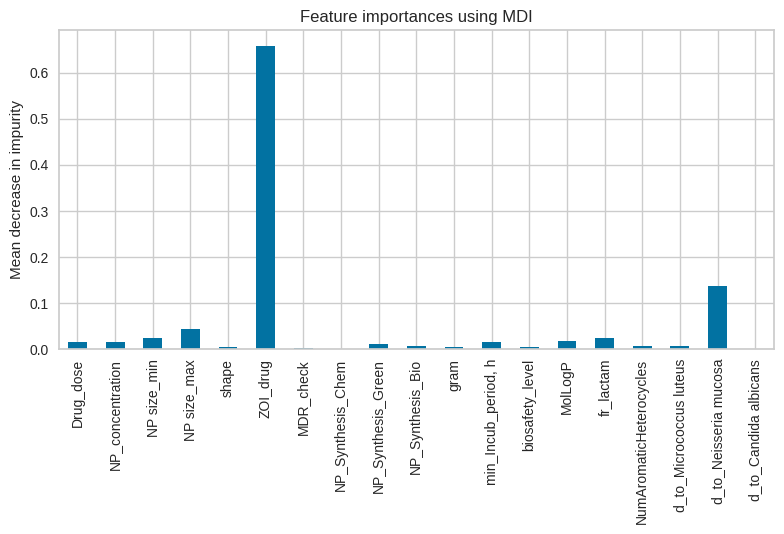

In [ ]:
importances = ex_tree.feature_importances_

ex_tree_importances = pd.Series(importances, index=x.drop(target_name))
std = np.std([ex_tree.feature_importances_ for tree in ex_tree.estimators_], axis=0)

fig, ax = plt.subplots()
ex_tree_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Обучаю модельку на полном датасете

In [ ]:
ex_tree = ExtraTreesRegressor(max_depth=10, min_samples_split=4, n_estimators=50, n_jobs=-1, random_state=123).fit(X, y)
print(f'R2 score on unseen data: {r2_score(y, ex_tree.predict(X))}')
print(f'RMSE score on unseen data: {(mean_squared_error(y, ex_tree.predict(X)))**0.5}')

R2 score on unseen data: 0.9603204442458724
RMSE score on unseen data: 1.6143039079476726


Сохроняю модельку

In [ ]:
# import pickle
filename = 'ExtraTreesRegressor.sav'
pickle.dump(ex_tree, open(filename, 'wb'))

# Нейронная сеть исходный код и нейронка работающая по весам

In [ ]:
# Список столбцов, которые нужно преобразовать в категориальные
categorical_columns = ['Elements', 'Material', 'Cell_type', 'Coat', 'Line_Primary_Cell', 'Animal', 'Cell_morphology', 'Cell_age', 'Cell_organ', 'Test', 'Test_indicator']

# Применение One-Hot Encoding к категориальным столбцам
data_df = pd.get_dummies(data_df, columns=categorical_columns)

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3077 entries, 0 to 3086
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Material                  3077 non-null   object 
 1   Diameter (nm)             3077 non-null   float64
 2   Zeta potential (mV)       3077 non-null   float64
 3   Cell_type                 3077 non-null   object 
 4   Concentration (g/L)       3077 non-null   float64
 5   Viability (%)             3077 non-null   float64
 6   Coat                      3077 non-null   object 
 7   Line_Primary_Cell         3077 non-null   object 
 8   Animal                    3077 non-null   object 
 9   Cell_morphology           3077 non-null   object 
 10  Cell_age                  3077 non-null   object 
 11  Cell_organ                3077 non-null   object 
 12  Time (h)                  3077 non-null   float64
 13  Test                      3077 non-null   object 
 14  Test_ind

In [ ]:
# _------------------
# Разделите данные на обучающий, валидационный и тестовый наборы
train_data, temp_data = train_test_split(data_df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Вывод размеров наборов данных для проверки
print("Размер обучающего набора:", len(train_data))
print("Размер валидационного набора:", len(val_data))
print("Размер тестового набора:", len(test_data))

Размер обучающего набора: 2153
Размер валидационного набора: 462
Размер тестового набора: 462


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Подготовка данных
X = data_df.drop(columns=['Viability (%)'])
y = data_df['Viability (%)']

# Определение категориальных и числовых признаков
categorical_features = ['Material', 'Cell_type', 'Coat', 'Line_Primary_Cell', 'Animal', 'Cell_morphology', 'Cell_age', 'Cell_organ', 'Test', 'Test_indicator', 'Elements']
numeric_features = ['Diameter (nm)', 'Zeta potential (mV)', 'Concentration (g/L)', 'Time (h)', 'Molecular weight (g/mol)', 'Electronegativity', 'Ionic radius']

# Создание пайплайна для предобработки данных
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Разделение данных на обучающий, валидационный и тестовый наборы
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Применение предобработки данных
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Создание модели MLP
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)  # Выходной слой без активации для регрессии
])

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Обучение модели с увеличенным числом эпох и регуляризацией
history = model.fit(X_train_processed, y_train, epochs=100, batch_size=64, validation_data=(X_val_processed, y_val), verbose=2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True)])

# Загрузка лучших весов модели
model.load_weights('best_model.h5')

# Оценка модели на тестовых данных
test_loss, test_mae = model.evaluate(X_test_processed, y_test)
print("Среднеквадратическая ошибка (MSE) на тестовых данных:", test_loss)
print("Средняя абсолютная ошибка (MAE) на тестовых данных:", test_mae)

Epoch 1/100


InvalidArgumentError: ignored

In [ ]:

# Загрузка данных
data = data_df

# Подготовка данных
X = data.drop(['Viability (%)'], axis=1).values
y = data['Viability (%)'].values

# Масштабирование признаков
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Создание модели нейронной сети
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Компиляция модели
model.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
history = model.fit(X_train, y_train, epochs=300, batch_size=64, validation_data=(X_test, y_test))

# Оценка точности модели на тестовой выборке
loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')

# Использование модели для предсказания значений
predictions = model.predict(X_test)

# Вывод предсказанных значений и соответствующих истинных значений
for i in range(len(predictions)):
    print(f'Predicted: {predictions[i]}, True: {y_test[i]}')

# Вычисление R2-score
r2 = r2_score(y_test, predictions)
print(f'R2-score: {r2}')

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Epoch 1/300
39/39 [==============================] - 1s 7ms/step - loss: 5955.1572 - val_loss: 4934.8257
Epoch 2/300
39/39 [==============================] - 0s 4ms/step - loss: 3086.0962 - val_loss: 1156.5570
Epoch 3/300
39/39 [==============================] - 0s 4ms/step - loss: 1073.4299 - val_loss: 941.5973
Epoch 4/300
39/39 [==============================] - 0s 3ms/step - loss: 934.2005 - val_loss: 865.4427
Epoch 5/300
39/39 [==============================] - 0s 4ms/step - loss: 861.9817 - val_loss: 820.4099
Epoch 6/300
39/39 [==============================] - 0s 4ms/step - loss: 817.0174 - val_loss: 789.4137
Epoch 7/300
39/39 [==============================] - 0s 3ms/step - loss: 785.8497 - val_loss: 767.7637
Epoch 8/300
39/39 [==============================] - 0s 4ms/step - loss: 763.1041 - val_loss: 754.3134
Epoch 9/300
39/39 [==============================] - 0s 4ms/step - loss: 748.4943 - val_loss: 737.3193
Epoch 10/300
39/39 [==============================] - 0s 4ms/step - 

KeyboardInterrupt: ignored

In [ ]:
model.save_weights('model_weights.h5')

## А эта нейронка кушает веса вместо обучения

In [ ]:
# Загрузка данных из файла CSV
data = df

# Подготовка данных
X = data.drop(['ZOI_drug_NP'], axis=1).values
y = data['ZOI_drug_NP'].values

# Масштабирование признаков
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Создание новой модели с такой же архитектурой
new_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Загрузка сохраненных весов
new_model.load_weights('model_weights.h5')

# Компиляция модели
new_model.compile(loss='mean_squared_error', optimizer='adam')

# Теперь можно использовать новую модель для предсказания значений
new_predictions = new_model.predict(X_test)

# Оценка точности модели на тестовой выборке
loss = new_model.evaluate(X_test, y_test)
print(f'Loss: {loss}')

# Использование модели для предсказания значений
predictions = new_model.predict(X_test)

# Вывод предсказанных значений и соответствующих истинных значений
for i in range(len(predictions)):
    print(f'Predicted: {predictions[i]}, True: {y_test[i]}')

# Вычисление R2-score
r2 = r2_score(y_test, predictions)
print(f'R2-score: {r2}')

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')


3/3 [==============================] - 0s 5ms/step - loss: 13.8457
Loss: 13.845684051513672
3/3 [==============================] - 0s 3ms/step
Predicted: [17.458275], True: 15.0
Predicted: [29.184471], True: 32.0
Predicted: [11.176393], True: 13.0
Predicted: [11.491494], True: 10.0
Predicted: [17.878057], True: 20.0
Predicted: [20.353416], True: 19.0
Predicted: [18.935173], True: 20.0
Predicted: [25.244123], True: 24.0
Predicted: [9.076443], True: 10.0
Predicted: [30.000975], True: 34.00000000000001
Predicted: [30.525951], True: 26.0
Predicted: [19.621359], True: 16.0
Predicted: [22.91909], True: 22.0
Predicted: [14.304628], True: 13.0
Predicted: [12.414443], True: 12.0
Predicted: [26.679348], True: 28.000000000000004
Predicted: [25.657505], True: 20.0
Predicted: [13.432115], True: 13.0
Predicted: [17.899332], True: 15.0
Predicted: [26.739834], True: 25.000000000000004
Predicted: [10.430043], True: 25.000000000000004
Predicted: [21.18845], True: 22.0
Predicted: [10.45237], True: 16.0
P